In [1]:
# Selecting libraries
import yfinance as yf
import pandas as pd
from datetime import timedelta, date, datetime
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
cryptos = ['BTC-USD','ETH-USD', 'FTM-USD', 'SNX-USD']  # Assets to select yfinance format 'MATIC-USD' , 'AVAX-USD'

weights = [0.25, 0.25, 0.25, 0.25]    # Weight allocation per asset

start_date = '2022-01-20'   # Start date for asset data download
live_date = '2023-08-01'    # Portfolio LIVE start date (for analytics)

Staking_Rewards = [1.00027, 1.00027, 1.00027, 1.00027] #[1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0]
Restaking_Period = 7

# Warning handling
if len(weights) != len(cryptos):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')

if sum((np.array(weights))) != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')

In [3]:
crypto_data = yf.download(cryptos, start=start_date)['Adj Close']
crypto_data = crypto_data.dropna()
crypto_data = crypto_data.reindex(columns=cryptos) #! Key to mantain structure
crypto_prices = crypto_data[cryptos].values

[*********************100%***********************]  4 of 4 completed


In [4]:
coins_df = pd.DataFrame(index=[crypto_data.index[0]])
portfolio_value = 10**6
for s,w in zip(cryptos, weights):
    coins_df[s+ '_coins'] = np.floor((portfolio_value * np.array(w)) / crypto_data[s][0]) #+ '_coins'

coins_df

,BTC-USD_coins,ETH-USD_coins,FTM-USD_coins,SNX-USD_coins
2022-01-20,6.0,83.0,91907.0,52410.0


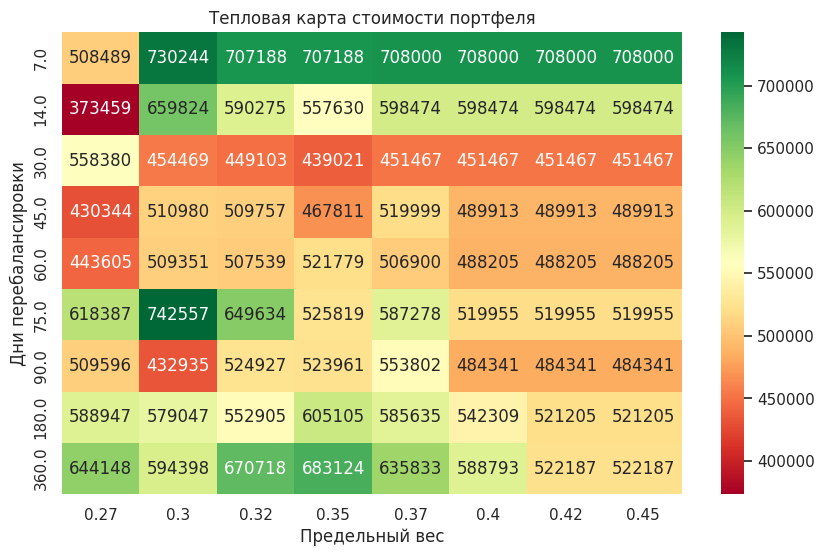

In [5]:
from multiprocessing.process import current_process
# REBALANCING ENGINE

Rebalance_days_list = [7, 14, 30, 45, 60, 75, 90, 180, 360]
target_weight_list = [0.27, 0.3, 0.32, 0.35, 0.37, 0.4, 0.42, 0.45]
sensitivity_list = []
#df = pd.DataFrame(pd.np.empty((0, 4)))
for i in range(0, len(Rebalance_days_list)):
  for j in range(0, len(target_weight_list)):
    Rebalance_dates = []
    Rebalance_days = int(Rebalance_days_list[i])
    target_weight = float(target_weight_list[j])
    td = pd.Timedelta(Rebalance_days, "d")
    portfolio_value = 10**6
    start_date = '2022-01-20'   # Start date for asset data download
    live_date = '2023-08-01'    # Portfolio LIVE start date (for analytics)Rebalance_dates = []
    def daterange(date1, date2):
        for n in range(int((((date2 - date1).days)+1)/Rebalance_days)+1):
            yield date1 + td*n
            #print(date1 + td*n)
    start_dt = datetime.strptime(start_date,"%Y-%m-%d").date()
    end_dt = datetime.strptime(live_date, "%Y-%m-%d").date()
    for dt in daterange(start_dt, end_dt):
        dt = dt.strftime('%Y-%m-%d') #    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
        Rebalance_dates.append(dt)
        #print(Rebalance_dates)
    # set initial shares on the first day
    coins_df = pd.DataFrame(index=[crypto_data.index[0]])

    for s,w in zip(cryptos, weights):
        coins_df[s+ '_coins'] = np.floor((portfolio_value * np.array(w)) / crypto_data[s][0]) #+ '_coinscoins_df.loc[crypto_data.index[0], :] = [((portfolio_value * w) / crypto_data[s][0]) for s,w in zip(cryptos, weights)]

    # initialize variables
    balance_day = crypto_data.index[0].day
    signal = False
    count = 0    # for loop count purpose

    # Store previous values in a dictionary
    prev_values = {}

    # Calculate portfolio value for the first day
    portfolio_value = sum([coins_df.loc[crypto_data.index[0], s + '_coins'] * crypto_data.loc[crypto_data.index[0], s] for s in cryptos])
    current_weights = weights
    for day in crypto_data.index:

        if day.date() == crypto_data.index[0].replace(tzinfo=None):
            coins_df.loc[day] = coins_df.loc[day] # First day

            # Store initial values as previous values
            for col in coins_df.columns:
                prev_values[col] = coins_df.loc[day, col]


        elif day.replace(tzinfo=None).strftime('%Y-%m-%d') in Rebalance_dates:
            signal = True
            # calculate new coins based on the new portfolio value and weights
            new_coins = [((portfolio_value * w) / crypto_data[s][day]) for s,w in zip(cryptos, weights)] # np.floor
            coins_df.loc[day, :] = new_coins
            #print(Rebalance_days, target_weight, f'Rebalance by period: {day.date()}, count: {count}') # uncomment to debug days ;)
            # Store new values as previous values
            for col in coins_df.columns:
                prev_values[col] = coins_df.loc[day, col]
                #print(coins_df.values)


        elif max(weights_current) > target_weight:
            signal = True
            # calculate new coins based on the new portfolio value and weights
            new_coins = [((portfolio_value * w) / crypto_data[s][day]) for s,w in zip(cryptos, weights)]
            coins_df.loc[day, :] = new_coins
            #print(Rebalance_days, target_weight, f'Rebalance by weight: {day.date()}, count: {count}') # uncomment to debug days ;)
            #Store new values as previous values
            for col in coins_df.columns:
                prev_values[col] = coins_df.loc[day, col]
                #print(coins_df.values)

        else:

            signal = False
            # Use previous values if it is not a rebalancing date
            Staking_Rewards_Adjusted = Staking_Rewards
            def Staking_Rewards_Adjuster(count):
              if count != 0 and count % Restaking_Period == 0:
                Staking_Rewards_Adjusted = (np.array(Staking_Rewards) - np.array(Staking_Rewards)/np.array(Staking_Rewards)) * Restaking_Period + np.array(Staking_Rewards)/np.array(Staking_Rewards)
              else:
                Staking_Rewards_Adjusted = np.array(Staking_Rewards) / np.array(Staking_Rewards)
              return Staking_Rewards_Adjusted
            Staking_Rewards_Adjusted = (Staking_Rewards_Adjuster(count))
            new_coins = np.array([prev_values[col] for col in coins_df.columns])* (Staking_Rewards_Adjusted)
            coins_df.loc[day, :] = new_coins
            for col in coins_df.columns:
                prev_values[col] = coins_df.loc[day, col]
                #print(coins_df.values)
            count += 1

        # Calculate asset values and portfolio value for the current day
        asset_values = [coins_df.loc[day, s + '_coins'] * crypto_data.loc[day, s] for s in cryptos]
        portfolio_value = sum(asset_values)
        weights_current = asset_values/portfolio_value
    #print("reb_days = " + str(Rebalance_days), "target weight =" + str(target_weight), portfolio_value)
    sensitivity_list.append([Rebalance_days, target_weight,'{:,}'.replace(',', ' ').format(int(portfolio_value))]) #Rebalance_days, target_weight,
#print(sensitivity_list)
sensitivity_df = pd.DataFrame(sensitivity_list, dtype = float)
sensitivity_df.columns = ['Rebalance_days', 'target_weight', 'portfolio_value']
sensitivity_df.set_index('Rebalance_days', inplace=True)
sensitivity_df_pivot = sensitivity_df.pivot(columns='target_weight', values='portfolio_value')
sensitivity_df_pivot

# heatmap из библиотеки seaborn
sns.set(font_scale=1)  # Настройка размера шрифта
plt.figure(figsize=(10, 6))  # Настройка размера графика
sns.heatmap(sensitivity_df_pivot, annot=True, fmt=".0f", cmap="RdYlGn")  # Создание тепловой карты

plt.title("Тепловая карта стоимости портфеля")
plt.xlabel("Предельный вес")
plt.ylabel("Дни перебалансировки")

plt.show()  # Отображение графика